# China Migration Network Analysis with Maritime-Inspired Measures

This notebook analyzes the Chinese internal migration network using network science measures inspired by the maritime shipping network paper:
- **Gateway-ness**: How well-connected a city is with cities outside its module
- **Provincial-ness**: How well-connected a city is within its own module  
- **Connector-ness**: How equally distributed connections are across modules
- **Economic small-world properties**: Efficiency vs cost trade-offs
- **Structural core detection**: Identifying hub cities that form the network backbone

All measures are computed **yearly** to track network evolution over time.

## 1. Setup and Data Loading

In [ ]:
import sys
sys.path.append('../')

import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')
from utils.graph.build import build_migration_network_for_year
from config import BaseConfig
from utils.metrics import compute_global_metrics
from tqdm import tqdm

config = BaseConfig()
# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load data
df = pd.read_csv(config.data_csv_path)

print(f"Data loaded: {len(df)} migration records")
print(f"Year range: {df['year_first_flow'].min()} - {df['year_current_flow'].max()}")
df.head()

Data loaded: 169989 migration records
Year range: 1944 - 2017


,current_province,current_city,current_county,current_members_live_with,gender,year_born,edu_level,hometown_code,hometown,year_current_flow,...,hometown_Name_County,hometown_lon,hometown_lat,first_Name_Province,first_Name_Prefecture,first_Name_County,first_lon,first_lat,current_lon,current_lat
0,广东省,深圳市,光明新区,4,2,1989,4,360681,江西省鹰潭市贵溪市,2015,...,贵溪市,117.186973,28.188428,江西省,南昌市,青山湖区,115.905297,28.719082,NaN,NaN
1,广东省,深圳市,光明新区,3,2,1981,5,360402,江西省九江市濂溪区,2015,...,濂溪区,116.039436,29.634605,广东省,深圳市,南山区,113.937903,22.554902,NaN,NaN
2,福建省,厦门市,同安区,4,2,1986,4,511623,四川省广安市邻水县,2013,...,邻水县,106.991830,30.258922,福建省,泉州市,丰泽区,118.617882,24.922059,118.102758,24.776209
3,新疆生产建设兵团,第六师,军户农场,3,1,1973,3,652301,新疆维吾尔自治区昌吉回族自治州昌吉市,2000,...,昌吉市,87.059347,44.091644,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,北京市,北京市,朝阳区,2,2,1984,5,511702,四川省达州市通川区,2010,...,通川区,107.432388,31.362205,四川省,成都市,武侯区,104.022906,30.610118,116.508837,39.951928


## 2. Network Building Function (Yearly)

In [ ]:
G_test = build_migration_network_for_year(df, 2010)
print(f"\nTest network for 2010:")
print(f"  Nodes (cities): {G_test.number_of_nodes()}")
print(f"  Edges (flows): {G_test.number_of_edges()}")
print(f"  Total migration volume: {sum(nx.get_edge_attributes(G_test, 'weight').values())}")


Test network for 2010:
  Nodes (cities): 377
  Edges (flows): 4794
  Total migration volume: 12704


## 3. Basic Topological Properties (Yearly Evolution)

In [ ]:
# Compute for all years
def get_global_metrics_over_years(df: pd.DataFrame, years: range) -> pd.DataFrame:
    yearly_metrics = {}
    for year in tqdm(years):
        G = build_migration_network_for_year(df, year)
        if G.number_of_nodes() > 10:  # Only analyze if network is substantial
            yearly_metrics[year] = compute_global_metrics(G)
    output_df = pd.DataFrame(yearly_metrics).T
    output_df.index.name = 'year'
    return output_df

# Compute global metrics over years, only include those who have made i tto their current flow
years = range(df['year_current_flow'].min(), df['year_current_flow'].max() + 1)
global_metrics_df = get_global_metrics_over_years(df, years)
global_metrics_df

100%|██████████| 70/70 [00:12<00:00,  5.66it/s] 


,n_nodes,n_edges,density,avg_degree,max_degree,avg_path_length,diameter,lcc_fraction,avg_clustering,transitivity,assortativity
year,,,,,,,,,,,
1958,17.0,12.0,0.044118,1.411765,7.0,1.666667,2.0,0.352941,0.000000,0.000000,-0.172549
1959,11.0,7.0,0.063636,1.272727,4.0,1.333333,2.0,0.272727,0.000000,0.000000,0.133333
1960,21.0,12.0,0.028571,1.142857,2.0,1.333333,2.0,0.142857,0.000000,0.000000,-0.333333
1961,13.0,11.0,0.070513,1.692308,8.0,1.928571,3.0,0.615385,0.000000,0.000000,-0.331845
1963,15.0,11.0,0.052381,1.466667,8.0,1.777778,2.0,0.600000,0.000000,0.000000,-0.571429
1964,17.0,11.0,0.040441,1.294118,4.0,1.600000,2.0,0.294118,0.000000,0.000000,-0.442623
1965,24.0,20.0,0.036232,1.500000,11.0,1.963636,3.0,0.458333,0.000000,0.000000,-0.271995
1966,21.0,15.0,0.035714,1.428571,9.0,1.750000,2.0,0.380952,0.000000,0.000000,-0.236967
1968,34.0,22.0,0.019608,1.294118,9.0,1.800000,2.0,0.294118,0.000000,0.000000,-0.288088


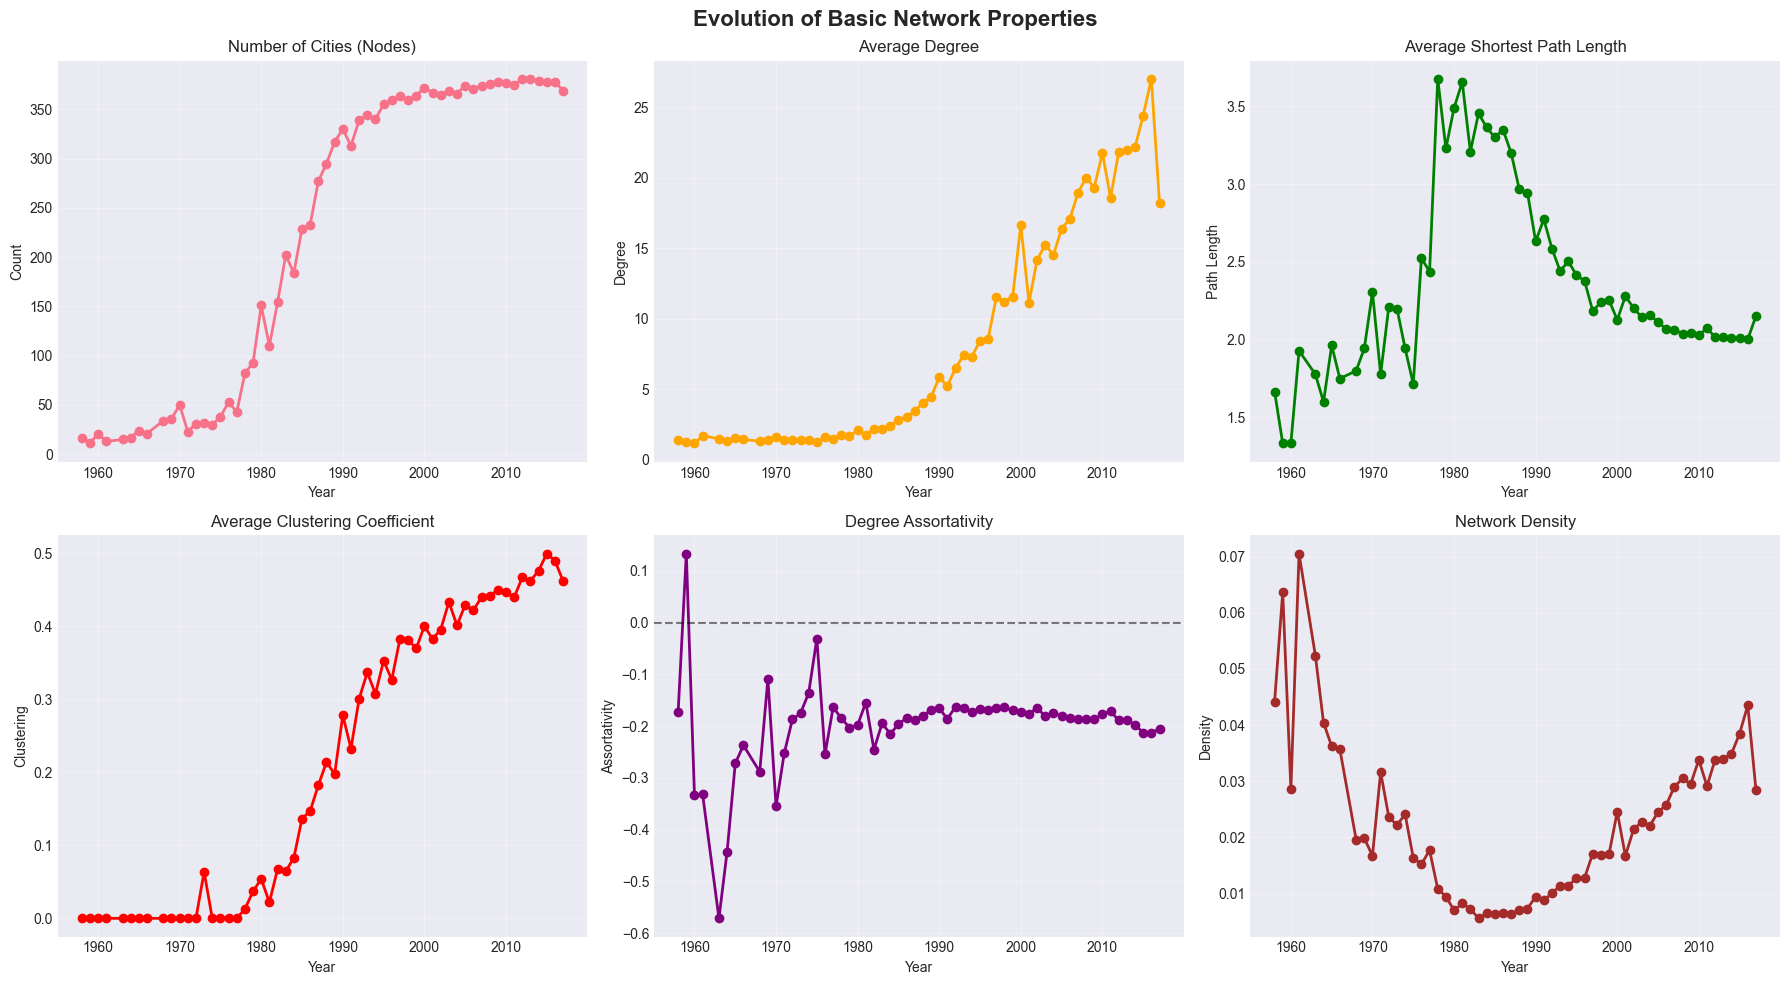

In [19]:
# Visualize evolution of basic properties
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Evolution of Basic Network Properties', fontsize=16, fontweight='bold')

# Network size
ax = axes[0, 0]
global_metrics_df['n_nodes'].plot(ax=ax, marker='o', linewidth=2)
ax.set_title('Number of Cities (Nodes)')
ax.set_xlabel('Year')
ax.set_ylabel('Count')
ax.grid(alpha=0.3)

# Average degree
ax = axes[0, 1]
global_metrics_df['avg_degree'].plot(ax=ax, marker='o', linewidth=2, color='orange')
ax.set_title('Average Degree')
ax.set_xlabel('Year')
ax.set_ylabel('Degree')
ax.grid(alpha=0.3)

# Average path length
ax = axes[0, 2]
global_metrics_df['avg_path_length'].plot(ax=ax, marker='o', linewidth=2, color='green')
ax.set_title('Average Shortest Path Length')
ax.set_xlabel('Year')
ax.set_ylabel('Path Length')
ax.grid(alpha=0.3)

# Clustering coefficient
ax = axes[1, 0]
global_metrics_df['avg_clustering'].plot(ax=ax, marker='o', linewidth=2, color='red')
ax.set_title('Average Clustering Coefficient')
ax.set_xlabel('Year')
ax.set_ylabel('Clustering')
ax.grid(alpha=0.3)

# Assortativity
ax = axes[1, 1]
global_metrics_df['assortativity'].plot(ax=ax, marker='o', linewidth=2, color='purple')
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.set_title('Degree Assortativity')
ax.set_xlabel('Year')
ax.set_ylabel('Assortativity')
ax.grid(alpha=0.3)

# Density
ax = axes[1, 2]
global_metrics_df['density'].plot(ax=ax, marker='o', linewidth=2, color='brown')
ax.set_title('Network Density')
ax.set_xlabel('Year')
ax.set_ylabel('Density')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Community Detection (Modular Structure)

Detecting communities is essential for computing gateway-ness, provincial-ness, and connector-ness measures.

In [ ]:
def detect_communities(G):
    """
    Detect communities using Louvain algorithm.
    Returns partition dict and modularity score.
    """
    # Convert to undirected for community detection
    G_und = G.to_undirected()
    
    # Use Louvain algorithm (need python-louvain package)
    try:
        import community as community_louvain
        partition = community_louvain.best_partition(G_und, weight='weight')
        modularity = community_louvain.modularity(partition, G_und, weight='weight')
    except ImportError:
        # Fallback to greedy modularity
        communities = nx.community.greedy_modularity_communities(G_und, weight='weight')
        partition = {}
        for i, community in enumerate(communities):
            for node in community:
                partition[node] = i
        modularity = nx.community.modularity(G_und, communities, weight='weight')
    
    return partition, modularity

# Test community detection
G_test = build_migration_network_for_year(df, 2015)
partition_test, mod_test = detect_communities(G_test)
n_communities = len(set(partition_test.values()))

print(f"\nCommunity detection test (2015):")
print(f"  Number of communities: {n_communities}")
print(f"  Modularity Q: {mod_test:.3f}")

# Count nodes per community
community_sizes = defaultdict(int)
for node, comm in partition_test.items():
    community_sizes[comm] += 1

print(f"\n  Community sizes: {dict(sorted(community_sizes.items()))}")


Community detection test (2015):
  Number of communities: 10
  Modularity Q: 0.363

  Community sizes: {0: 60, 1: 72, 2: 41, 3: 2, 4: 16, 5: 47, 6: 47, 7: 15, 8: 46, 9: 32}


## 5. Gateway-ness, Provincial-ness, and Connector-ness

These measures capture different hub roles:
- **Gateway-ness (B)**: Connections to cities outside own module
- **Provincial-ness (Z)**: Connections to cities within own module  
- **Connector-ness (P)**: Equal distribution of connections across modules

In [21]:
def compute_hub_measures(G, partition):
    """
    Compute gateway-ness (B), provincial-ness (Z), and connector-ness (P)
    for all nodes in the network.
    
    Based on definitions from the maritime paper.
    """
    G_und = G.to_undirected()
    measures = {}
    
    # Group nodes by community
    communities = defaultdict(list)
    for node, comm in partition.items():
        communities[comm].append(node)
    
    for node in G_und.nodes():
        node_comm = partition[node]
        neighbors = list(G_und.neighbors(node))
        
        if len(neighbors) == 0:
            measures[node] = {'B': 0, 'Z': 0, 'P': 0}
            continue
        
        # Count inside-module and outside-module connections
        k_inside = sum(1 for n in neighbors if partition[n] == node_comm)
        k_outside = sum(1 for n in neighbors if partition[n] != node_comm)
        
        # Compute Z-score for inside-module degree (Provincial-ness)
        community_nodes = communities[node_comm]
        k_inside_values = []
        for n in community_nodes:
            if n in G_und:
                n_neighbors = list(G_und.neighbors(n))
                k_inside_n = sum(1 for nn in n_neighbors if partition[nn] == node_comm)
                k_inside_values.append(k_inside_n)
        
        if len(k_inside_values) > 1:
            mean_k_inside = np.mean(k_inside_values)
            std_k_inside = np.std(k_inside_values)
            Z = (k_inside - mean_k_inside) / std_k_inside if std_k_inside > 0 else 0
        else:
            Z = 0
        
        # Compute Z-score for outside-module degree (Gateway-ness)
        k_outside_values = []
        for n in community_nodes:
            if n in G_und:
                n_neighbors = list(G_und.neighbors(n))
                k_outside_n = sum(1 for nn in n_neighbors if partition[nn] != node_comm)
                k_outside_values.append(k_outside_n)
        
        if len(k_outside_values) > 1:
            mean_k_outside = np.mean(k_outside_values)
            std_k_outside = np.std(k_outside_values)
            B = (k_outside - mean_k_outside) / std_k_outside if std_k_outside > 0 else 0
        else:
            B = 0
        
        # Compute participation coefficient (Connector-ness)
        k_total = len(neighbors)
        k_per_module = defaultdict(int)
        for n in neighbors:
            k_per_module[partition[n]] += 1
        
        P = 1 - sum((k_s / k_total) ** 2 for k_s in k_per_module.values())
        
        measures[node] = {'B': B, 'Z': Z, 'P': P}
    
    return measures

# Test hub measures
hub_measures_test = compute_hub_measures(G_test, partition_test)

# Show top cities by each measure
print("\n=== Top 10 Cities by Gateway-ness (B) ===")
top_B = sorted(hub_measures_test.items(), key=lambda x: x[1]['B'], reverse=True)[:10]
for city, measures in top_B:
    print(f"  {city}: B={measures['B']:.2f}, Z={measures['Z']:.2f}, P={measures['P']:.2f}")

print("\n=== Top 10 Cities by Provincial-ness (Z) ===")
top_Z = sorted(hub_measures_test.items(), key=lambda x: x[1]['Z'], reverse=True)[:10]
for city, measures in top_Z:
    print(f"  {city}: B={measures['B']:.2f}, Z={measures['Z']:.2f}, P={measures['P']:.2f}")

print("\n=== Top 10 Cities by Connector-ness (P) ===")
top_P = sorted(hub_measures_test.items(), key=lambda x: x[1]['P'], reverse=True)[:10]
for city, measures in top_P:
    print(f"  {city}: B={measures['B']:.2f}, Z={measures['Z']:.2f}, P={measures['P']:.2f}")


=== Top 10 Cities by Gateway-ness (B) ===
  nan: B=6.43, Z=6.29, P=0.87
  上海市: B=5.12, Z=3.28, P=0.82
  重庆市: B=4.68, Z=3.23, P=0.82
  深圳市: B=4.56, Z=3.35, P=0.82
  天津市: B=4.28, Z=2.42, P=0.85
  西安市: B=4.12, Z=2.62, P=0.84
  广州市: B=4.01, Z=3.47, P=0.82
  昆明市: B=3.73, Z=2.76, P=0.85
  北京市: B=3.56, Z=3.53, P=0.86
  哈尔滨市: B=3.53, Z=2.34, P=0.79

=== Top 10 Cities by Provincial-ness (Z) ===
  nan: B=6.43, Z=6.29, P=0.87
  成都市: B=2.40, Z=3.57, P=0.79
  北京市: B=3.56, Z=3.53, P=0.86
  广州市: B=4.01, Z=3.47, P=0.82
  深圳市: B=4.56, Z=3.35, P=0.82
  上海市: B=5.12, Z=3.28, P=0.82
  重庆市: B=4.68, Z=3.23, P=0.82
  大连市: B=2.65, Z=3.23, P=0.74
  沈阳市: B=3.33, Z=3.08, P=0.76
  乌鲁木齐市: B=1.69, Z=2.99, P=0.77

=== Top 10 Cities by Connector-ness (P) ===
  nan: B=6.43, Z=6.29, P=0.87
  北京市: B=3.56, Z=3.53, P=0.86
  天津市: B=4.28, Z=2.42, P=0.85
  西双版纳傣族自治州: B=0.02, Z=-0.35, P=0.85
  漯河市: B=-0.26, Z=-0.51, P=0.85
  昆明市: B=3.73, Z=2.76, P=0.85
  石家庄市: B=1.59, Z=1.83, P=0.84
  郑州市: B=2.97, Z=2.38, P=0.84
  南阳市: B=0.25

## 6. Yearly Evolution of Hub Measures

Computing hub measures for each year...
  1958: Q=0.526, 6 communities
  1959: Q=0.663, 5 communities
  1960: Q=0.875, 9 communities
  1961: Q=0.455, 4 communities
  1963: Q=0.446, 4 communities
  1964: Q=0.760, 6 communities
  1965: Q=0.558, 8 communities
  1966: Q=0.642, 7 communities
  1968: Q=0.793, 12 communities
  1969: Q=0.772, 12 communities
  1970: Q=0.533, 15 communities
  1971: Q=0.571, 8 communities
  1972: Q=0.635, 11 communities
  1973: Q=0.765, 12 communities
  1974: Q=0.714, 11 communities
  1975: Q=0.844, 16 communities
  1976: Q=0.603, 17 communities
  1977: Q=0.609, 18 communities
  1978: Q=0.660, 20 communities
  1979: Q=0.704, 27 communities
  1980: Q=0.621, 32 communities
  1981: Q=0.720, 24 communities
  1982: Q=0.603, 31 communities
  1983: Q=0.615, 34 communities
  1984: Q=0.552, 33 communities
  1985: Q=0.518, 20 communities
  1986: Q=0.507, 19 communities
  1987: Q=0.469, 18 communities
  1988: Q=0.430, 16 communities
  1989: Q=0.400, 13 communities
  1990: Q

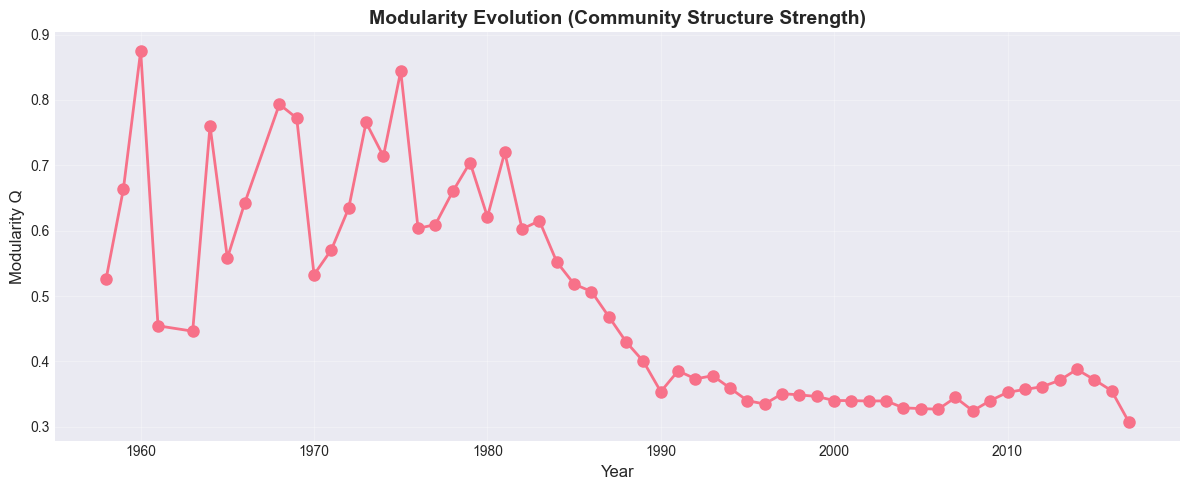

In [ ]:
# Compute hub measures for all years
yearly_hub_measures = {}
yearly_modularity = {}

print("Computing hub measures for each year...")
for year in years:
    G = build_migration_network_for_year(df, year)
    if G.number_of_nodes() > 10:
        partition, modularity = detect_communities(G)
        hub_measures = compute_hub_measures(G, partition)
        
        yearly_hub_measures[year] = hub_measures
        yearly_modularity[year] = modularity
        
        n_communities = len(set(partition.values()))
        print(f"  {year}: Q={modularity:.3f}, {n_communities} communities")

# Plot modularity evolution
plt.figure(figsize=(12, 5))
plt.plot(list(yearly_modularity.keys()), list(yearly_modularity.values()), 
         marker='o', linewidth=2, markersize=8)
plt.title('Modularity Evolution (Community Structure Strength)', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Modularity Q', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Major cities (appear in ≥15 years): 374
Examples: ['南京市', '平顶山市', '晋中市', nan, '大同市', '邢台市', '包头市', '三亚市', '海南省', '省直辖']


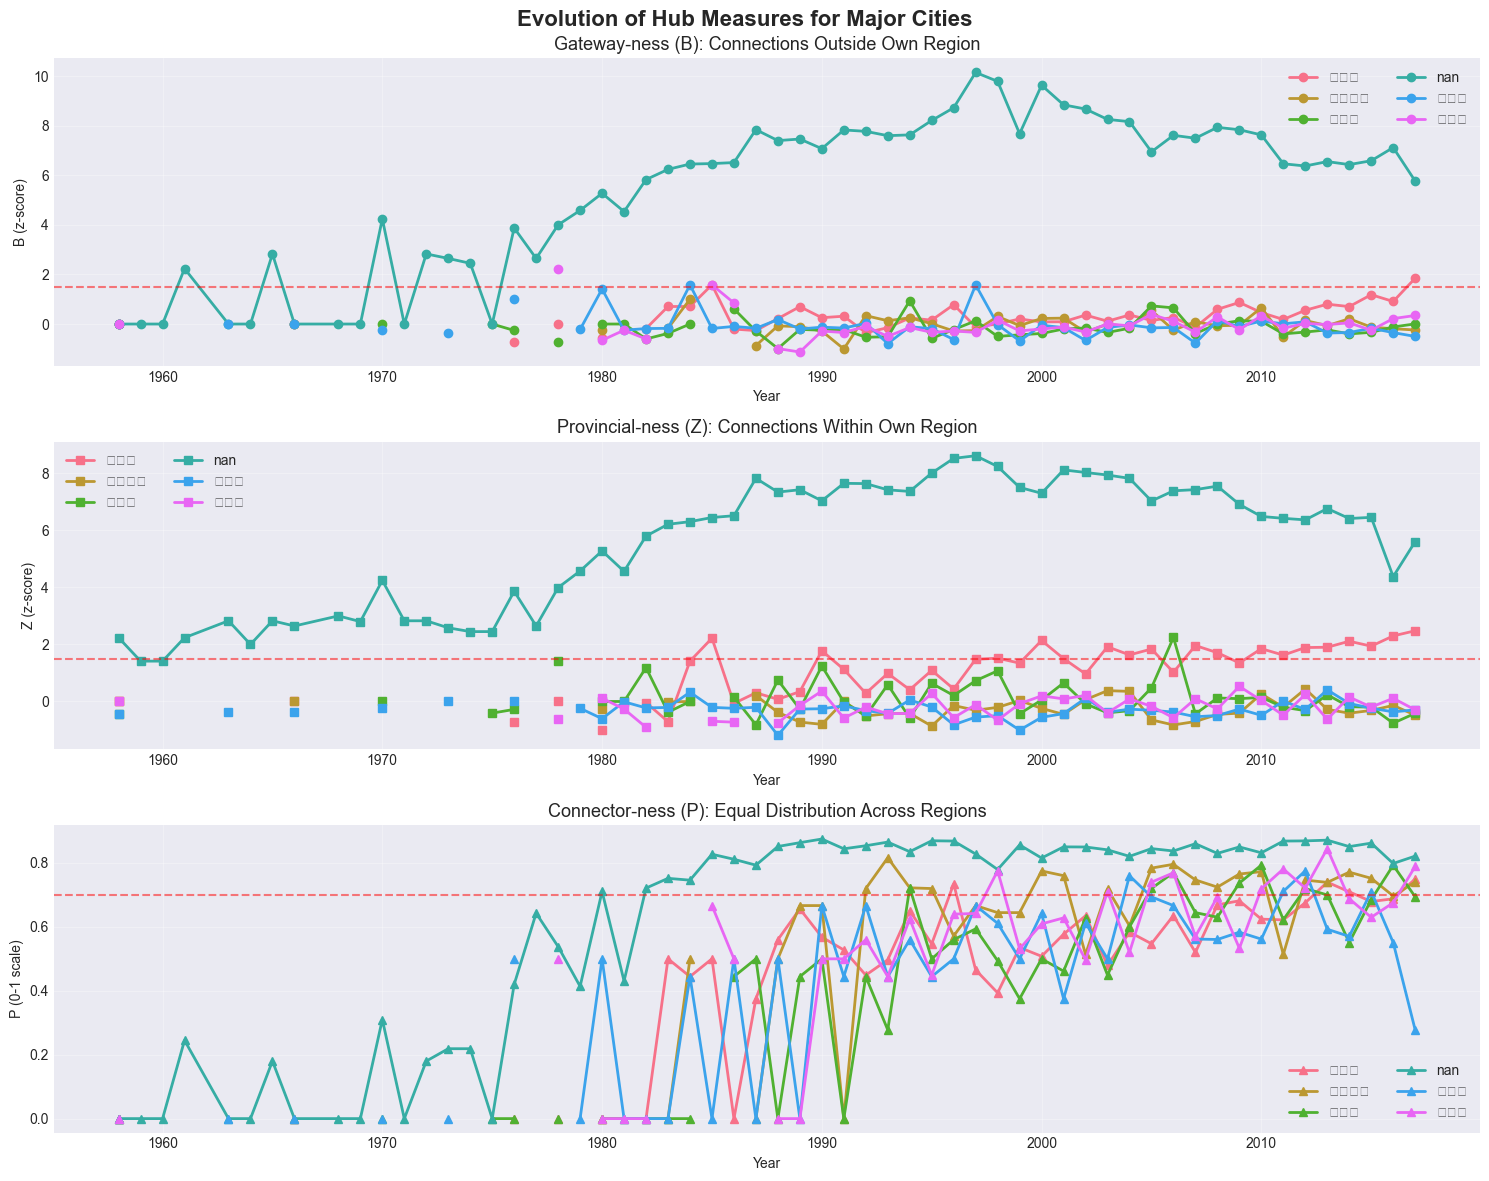

In [23]:
# Analyze specific cities' hub measure evolution
# Select major cities that appear frequently
city_counts = defaultdict(int)
for year, measures in yearly_hub_measures.items():
    for city in measures.keys():
        city_counts[city] += 1

# Get cities that appear in at least 15 years
major_cities = [city for city, count in city_counts.items() if count >= 15]
print(f"\nMajor cities (appear in ≥15 years): {len(major_cities)}")
print(f"Examples: {major_cities[:10]}")

# Select top cities to track
cities_to_track = major_cities[:6]  # Track top 6 cities

# Extract time series for each measure
city_B_series = {city: [] for city in cities_to_track}
city_Z_series = {city: [] for city in cities_to_track}
city_P_series = {city: [] for city in cities_to_track}
years_available = []

for year in sorted(yearly_hub_measures.keys()):
    measures = yearly_hub_measures[year]
    years_available.append(year)
    
    for city in cities_to_track:
        if city in measures:
            city_B_series[city].append(measures[city]['B'])
            city_Z_series[city].append(measures[city]['Z'])
            city_P_series[city].append(measures[city]['P'])
        else:
            city_B_series[city].append(np.nan)
            city_Z_series[city].append(np.nan)
            city_P_series[city].append(np.nan)

# Plot evolution
fig, axes = plt.subplots(3, 1, figsize=(15, 12))
fig.suptitle('Evolution of Hub Measures for Major Cities', fontsize=16, fontweight='bold')

# Gateway-ness
ax = axes[0]
for city in cities_to_track:
    ax.plot(years_available, city_B_series[city], marker='o', label=city, linewidth=2)
ax.set_title('Gateway-ness (B): Connections Outside Own Region', fontsize=13)
ax.set_xlabel('Year')
ax.set_ylabel('B (z-score)')
ax.legend(loc='best', ncol=2)
ax.grid(alpha=0.3)
ax.axhline(y=1.5, color='red', linestyle='--', alpha=0.5, label='Gateway hub threshold')

# Provincial-ness
ax = axes[1]
for city in cities_to_track:
    ax.plot(years_available, city_Z_series[city], marker='s', label=city, linewidth=2)
ax.set_title('Provincial-ness (Z): Connections Within Own Region', fontsize=13)
ax.set_xlabel('Year')
ax.set_ylabel('Z (z-score)')
ax.legend(loc='best', ncol=2)
ax.grid(alpha=0.3)
ax.axhline(y=1.5, color='red', linestyle='--', alpha=0.5, label='Provincial hub threshold')

# Connector-ness
ax = axes[2]
for city in cities_to_track:
    ax.plot(years_available, city_P_series[city], marker='^', label=city, linewidth=2)
ax.set_title('Connector-ness (P): Equal Distribution Across Regions', fontsize=13)
ax.set_xlabel('Year')
ax.set_ylabel('P (0-1 scale)')
ax.legend(loc='best', ncol=2)
ax.grid(alpha=0.3)
ax.axhline(y=0.7, color='red', linestyle='--', alpha=0.5, label='Connector hub threshold')

plt.tight_layout()
plt.show()

## 7. Hub Classification and Structural Core Detection

Following the maritime paper, we classify cities as:
- **Gateway hubs**: B ≥ 1.5
- **Provincial hubs**: Z ≥ 1.5
- **Connector hubs**: P ≥ 0.7

In [24]:
def classify_hubs(hub_measures, B_threshold=1.5, Z_threshold=1.5, P_threshold=0.7):
    """
    Classify nodes as gateway, provincial, or connector hubs.
    """
    gateway_hubs = []
    provincial_hubs = []
    connector_hubs = []
    
    for node, measures in hub_measures.items():
        if measures['B'] >= B_threshold:
            gateway_hubs.append(node)
        if measures['Z'] >= Z_threshold:
            provincial_hubs.append(node)
        if measures['P'] >= P_threshold:
            connector_hubs.append(node)
    
    return {
        'gateway': gateway_hubs,
        'provincial': provincial_hubs,
        'connector': connector_hubs
    }

# Classify hubs for each year
yearly_hub_classification = {}

for year, hub_measures in yearly_hub_measures.items():
    classification = classify_hubs(hub_measures)
    yearly_hub_classification[year] = classification
    
    print(f"\n{year}:")
    print(f"  Gateway hubs: {len(classification['gateway'])}")
    print(f"  Provincial hubs: {len(classification['provincial'])}")
    print(f"  Connector hubs: {len(classification['connector'])}")


1958:
  Gateway hubs: 0
  Provincial hubs: 1
  Connector hubs: 0

1959:
  Gateway hubs: 0
  Provincial hubs: 0
  Connector hubs: 0

1960:
  Gateway hubs: 0
  Provincial hubs: 0
  Connector hubs: 0

1961:
  Gateway hubs: 1
  Provincial hubs: 1
  Connector hubs: 0

1963:
  Gateway hubs: 0
  Provincial hubs: 1
  Connector hubs: 0

1964:
  Gateway hubs: 0
  Provincial hubs: 2
  Connector hubs: 0

1965:
  Gateway hubs: 1
  Provincial hubs: 1
  Connector hubs: 0

1966:
  Gateway hubs: 0
  Provincial hubs: 1
  Connector hubs: 0

1968:
  Gateway hubs: 0
  Provincial hubs: 1
  Connector hubs: 0

1969:
  Gateway hubs: 0
  Provincial hubs: 2
  Connector hubs: 0

1970:
  Gateway hubs: 1
  Provincial hubs: 1
  Connector hubs: 0

1971:
  Gateway hubs: 0
  Provincial hubs: 1
  Connector hubs: 0

1972:
  Gateway hubs: 1
  Provincial hubs: 1
  Connector hubs: 0

1973:
  Gateway hubs: 1
  Provincial hubs: 1
  Connector hubs: 0

1974:
  Gateway hubs: 1
  Provincial hubs: 2
  Connector hubs: 0

1975:
  G

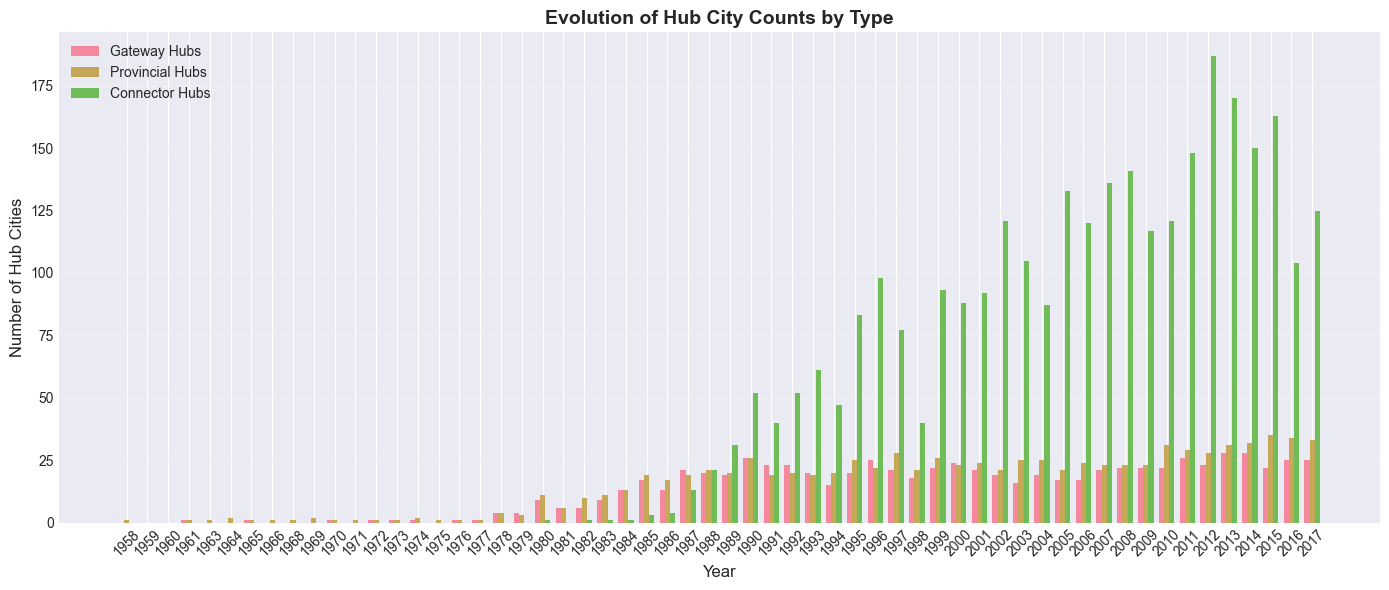

In [25]:
# Plot evolution of hub counts
hub_counts_data = {
    'Gateway': [],
    'Provincial': [],
    'Connector': []
}

years_list = sorted(yearly_hub_classification.keys())
for year in years_list:
    classification = yearly_hub_classification[year]
    hub_counts_data['Gateway'].append(len(classification['gateway']))
    hub_counts_data['Provincial'].append(len(classification['provincial']))
    hub_counts_data['Connector'].append(len(classification['connector']))

fig, ax = plt.subplots(figsize=(14, 6))
width = 0.25
x = np.arange(len(years_list))

ax.bar(x - width, hub_counts_data['Gateway'], width, label='Gateway Hubs', alpha=0.8)
ax.bar(x, hub_counts_data['Provincial'], width, label='Provincial Hubs', alpha=0.8)
ax.bar(x + width, hub_counts_data['Connector'], width, label='Connector Hubs', alpha=0.8)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of Hub Cities', fontsize=12)
ax.set_title('Evolution of Hub City Counts by Type', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(years_list, rotation=45)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Economic Small-World Analysis

Analyze efficiency vs. cost trade-offs in the migration network.

In [ ]:
def haversine_distance(lon1, lat1, lon2, lat2):
    """
    Calculate great circle distance between two points on Earth.
    Returns distance in kilometers.
    """
    # Convert to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Earth radius in km
    r = 6371
    return c * r

def compute_economic_small_world(G):
    """
    Compute economic small-world measures:
    - Global efficiency
    - Local efficiency  
    - Cost (sum of physical distances)
    """
    G_und = G.to_undirected()
    
    # Add physical distances to edges
    for u, v in G_und.edges():
        if 'lon' in G_und.nodes[u] and 'lon' in G_und.nodes[v]:
            lon1, lat1 = G_und.nodes[u]['lon'], G_und.nodes[u]['lat']
            lon2, lat2 = G_und.nodes[v]['lon'], G_und.nodes[v]['lat']
            dist = haversine_distance(lon1, lat1, lon2, lat2)
            G_und[u][v]['distance'] = dist
        else:
            G_und[u][v]['distance'] = 1  # Default if coordinates missing
    
    # Global efficiency (using distance-weighted paths)
    n = G_und.number_of_nodes()
    if n <= 1:
        return {'global_efficiency': 0, 'local_efficiency': 0, 'cost': 0}
    
    # Calculate efficiency as 1/distance for all pairs
    total_efficiency = 0
    for u in G_und.nodes():
        path_lengths = nx.single_source_dijkstra_path_length(G_und, u, weight='distance')
        for v, dist in path_lengths.items():
            if u != v and dist > 0:
                total_efficiency += 1 / dist
    
    global_efficiency = total_efficiency / (n * (n - 1))
    
    # Local efficiency (average efficiency of neighborhoods)
    local_efficiencies = []
    for node in G_und.nodes():
        neighbors = list(G_und.neighbors(node))
        if len(neighbors) > 1:
            subgraph = G_und.subgraph(neighbors)
            if subgraph.number_of_edges() > 0:
                # Compute efficiency of subgraph
                sub_eff = 0
                n_sub = len(neighbors)
                for u in neighbors:
                    try:
                        path_lengths = nx.single_source_dijkstra_path_length(
                            subgraph, u, weight='distance')
                        for v, dist in path_lengths.items():
                            if u != v and dist > 0:
                                sub_eff += 1 / dist
                    except:
                        pass
                
                if n_sub > 1:
                    local_efficiencies.append(sub_eff / (n_sub * (n_sub - 1)))
    
    local_efficiency = np.mean(local_efficiencies) if local_efficiencies else 0
    
    # Cost (sum of all edge distances)
    cost = sum(G_und[u][v]['distance'] for u, v in G_und.edges())
    
    return {
        'global_efficiency': global_efficiency,
        'local_efficiency': local_efficiency,
        'cost': cost
    }

# Compute for all years
yearly_economic_sw = {}

print("Computing economic small-world properties...")
for year in years:
    G = build_migration_network_for_year(df, year)
    if G.number_of_nodes() > 10:
        esw = compute_economic_small_world(G)
        yearly_economic_sw[year] = esw
        print(f"  {year}: Eglobal={esw['global_efficiency']:.6f}, "
              f"Elocal={esw['local_efficiency']:.6f}, Cost={esw['cost']:.0f}km")

# Convert to DataFrame
esw_df = pd.DataFrame(yearly_economic_sw).T
esw_df.index.name = 'year'

Computing economic small-world properties...
  1958: Eglobal=0.000153, Elocal=0.000000, Cost=nankm
  1959: Eglobal=0.000141, Elocal=0.000000, Cost=nankm
  1960: Eglobal=0.000243, Elocal=0.000000, Cost=nankm
  1961: Eglobal=0.000092, Elocal=0.000000, Cost=nankm
  1963: Eglobal=0.000154, Elocal=0.000000, Cost=nankm
  1964: Eglobal=0.000355, Elocal=0.000000, Cost=nankm
  1965: Eglobal=0.000087, Elocal=0.000000, Cost=nankm
  1966: Eglobal=0.000253, Elocal=0.000000, Cost=nankm
  1968: Eglobal=0.000100, Elocal=0.000000, Cost=nankm
  1969: Eglobal=0.000092, Elocal=0.000000, Cost=nankm
  1970: Eglobal=0.000078, Elocal=0.000000, Cost=nankm
  1971: Eglobal=0.000079, Elocal=0.000000, Cost=nankm
  1972: Eglobal=0.000135, Elocal=0.000000, Cost=nankm
  1973: Eglobal=0.000091, Elocal=0.000000, Cost=nankm
  1974: Eglobal=0.000165, Elocal=0.000000, Cost=nankm
  1975: Eglobal=0.000141, Elocal=0.000000, Cost=nankm
  1976: Eglobal=0.000112, Elocal=0.000000, Cost=nankm
  1977: Eglobal=0.000090, Elocal=0.00

ValueError: ('Contradictory paths found:', 'negative weights?')

In [ ]:
# Plot economic small-world properties
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Economic Small-World Properties Evolution', fontsize=16, fontweight='bold')

# Global efficiency
ax = axes[0]
esw_df['global_efficiency'].plot(ax=ax, marker='o', linewidth=2, color='green')
ax.set_title('Global Efficiency')
ax.set_xlabel('Year')
ax.set_ylabel('Efficiency')
ax.grid(alpha=0.3)

# Local efficiency
ax = axes[1]
esw_df['local_efficiency'].plot(ax=ax, marker='o', linewidth=2, color='blue')
ax.set_title('Local Efficiency')
ax.set_xlabel('Year')
ax.set_ylabel('Efficiency')
ax.grid(alpha=0.3)

# Cost
ax = axes[2]
esw_df['cost'].plot(ax=ax, marker='o', linewidth=2, color='red')
ax.set_title('Network Cost (Total Distance)')
ax.set_xlabel('Year')
ax.set_ylabel('Distance (km)')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Summary Statistics and Export

In [ ]:
# Create comprehensive summary table
summary_df = props_df.copy()
summary_df['modularity'] = pd.Series(yearly_modularity)
summary_df['global_efficiency'] = esw_df['global_efficiency']
summary_df['local_efficiency'] = esw_df['local_efficiency']
summary_df['cost_km'] = esw_df['cost']

# Add hub counts
summary_df['n_gateway_hubs'] = [len(yearly_hub_classification.get(y, {}).get('gateway', []))
                                for y in summary_df.index]
summary_df['n_provincial_hubs'] = [len(yearly_hub_classification.get(y, {}).get('provincial', []))
                                   for y in summary_df.index]
summary_df['n_connector_hubs'] = [len(yearly_hub_classification.get(y, {}).get('connector', []))
                                  for y in summary_df.index]

print("\n=== Comprehensive Network Summary ===")
print(summary_df)

# Export to CSV
summary_df.to_csv('/mnt/user-data/outputs/china_migration_network_summary.csv')
print("\nSummary exported to: china_migration_network_summary.csv")

## 10. Key Insights

This analysis reveals:

1. **Network Growth**: How the migration network expands over time in terms of cities and connections

2. **Community Structure**: The modular organization reflects regional migration patterns

3. **Hub Evolution**: 
   - Gateway hubs connect different regions (economic centers attracting migrants)
   - Provincial hubs dominate within regions (regional capitals)
   - Connector hubs bridge multiple regions (strategic transit cities)

4. **Efficiency vs Cost**: The network balances migration efficiency with geographic constraints

5. **Temporal Dynamics**: Changes in hub roles and network structure reflect socioeconomic development